# Análisis de series temporales

## Introducción

### Propósito del proyecto

<!-- TODO: Explicar el propósito del proyecto -->
En este proyecto de ciencia de datos se desarrollarán técnicas de regresión mediante series temporales (_time series_) con el objetivo de intentar predecir el precio de acciones en bolsa de diferentes empresas farmacéuticas.

En concreto se desea predecir el precio de las acciones de la farmacéutica _Pfizer_ utilizando un conjunto de datos con registros de los últimos 5 años (2019-2024). Para ayudar a la predicción, se cuentan también con información de las siguientes compañías farmacéuticas:

* _Moderna_
* _AstraZeneca_
* _Johnson & Johnson_

Esta información adicional se utilizará para comprobar posibles relaciones entre las subidas o valores de las otras empresas frente al estado de las acciones de _Pfizer_.

Debido al comportamiento impredecible de la bolsa en corto plazo, se propone realizar una predicción a medio plazo, buscando predecir los precios de las acciones cada semana/dos semanas en vez de de manera diaria. Este punto será desarrollado más adelante.

Para este estudio se ha planteado utilizar tres tipos de modelos de series temporales:

* Series temporales univariadas.
* Series temporales multivariadas.
* Series temporales sobre datos de tipo panel.

Esta información ha sido extraída del sitio web [Yahoo Finance](https://finance.yahoo.com/).

### Librerías utilizadas

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Descripción de los conjuntos de datos utilizados

<!-- TODO: Explicar conjuntos de datos utilizados -->
Los conjuntos de datos se encuentra almacenados en los siguientes ficheros _.csv_:

* `AZN.csv` (_AstraZeneca_)
* `JNJ.csv` (_Johnson & Johnson_)
* `MRNA.csv` (_Moderna_)
* `PFE.csv` (_Pfizer_)

Al tratarse de datos de valores en bolsa, la estructura de todos los conjuntos de datos es la misma en todos los ficheros:

|Campo|Definición|
|-|-|
|`Date`|Fecha de registro de precios|
|`Open`|Precio inicial al momento del registro|
|`High`|Precio más alto a lo largo del día|
|`Low` |Precio más bajo a lo largo del día|
|`Close`|Precio de cierre al final del día|
|`Adj Close`|Precio de cierre ajustado al final del día|
|`Volume`|Número de acciones vendidas|

In [96]:
pfizer_data = pd.read_csv('../data/input/stock/PFE.csv')

display(pfizer_data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-10,41.024670,41.024670,40.483871,40.863377,33.336327,15275727
1,2019-06-11,40.986717,41.081593,40.370018,40.483871,33.026730,18813162
2,2019-06-12,40.294117,40.958256,40.284630,40.872864,33.344067,16296843
3,2019-06-13,40.863377,40.929790,40.199242,40.322582,32.895149,14464042
4,2019-06-14,40.341557,40.673622,40.303604,40.569260,33.096386,13197872


In [97]:
azeneca_data = pd.read_csv('../data/input/stock/AZN.csv')

display(azeneca_data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-10,39.160000,39.720001,39.080002,39.590000,34.930904,2928900
1,2019-06-11,39.689999,39.740002,39.310001,39.389999,34.754440,2378100
2,2019-06-12,39.520000,39.990002,39.520000,39.930000,35.230892,2507300
3,2019-06-13,39.810001,40.009998,39.599998,39.910000,35.213245,2020000
4,2019-06-14,39.680000,39.959999,39.619999,39.669998,35.001492,1477800


In [98]:
jnj_data = pd.read_csv('../data/input/stock/AZN.csv')

display(jnj_data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-10,39.160000,39.720001,39.080002,39.590000,34.930904,2928900
1,2019-06-11,39.689999,39.740002,39.310001,39.389999,34.754440,2378100
2,2019-06-12,39.520000,39.990002,39.520000,39.930000,35.230892,2507300
3,2019-06-13,39.810001,40.009998,39.599998,39.910000,35.213245,2020000
4,2019-06-14,39.680000,39.959999,39.619999,39.669998,35.001492,1477800


In [99]:
moderna_data = pd.read_csv('../data/input/stock/MRNA.csv')

display(moderna_data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-10,17.850000,17.990000,15.670000,15.670000,15.670000,2574700
1,2019-06-11,16.090000,16.879999,15.750000,16.000000,16.000000,5614200
2,2019-06-12,16.110001,16.360001,15.620000,16.299999,16.299999,2042400
3,2019-06-13,16.420000,17.590000,16.049999,16.160000,16.160000,1607300
4,2019-06-14,16.250000,16.674999,15.320000,15.400000,15.400000,2080000


### Selección de variables independientes

Como variable de estudio se ha escogido el precio ajustado de cierre de ventas de acciones (`Adj Close`), por lo que solo se estudiarán esas variables independientes.

In [ ]:
pfizer_data = pfizer_data.fi

### Ajustes de granularidad

<!-- TODO: Explicar que se reducira de dias a semanas o grupos de 2 semanas -->
Anteriormente se explicó que el comportamiento de las acciones en bolsa tiende a ser caótico a corto plazo pero relativamente estable a largo plazo.

Como el proyecto busca identificar patrones en el precio de las acciones de _Pfizer_, se ha decidido reducir la granularidad temporal de los conjuntos de datos, para trabajar con información en semanas en vez de en días. Concretamente, se ha decidido condensar el conjunto de datos en intervalos de 1 semana, siendo el valor de $y$ de cada semana la media de cada uno de sus días.

In [90]:
def fill_df_date_range(df: pd.DataFrame) -> pd.DataFrame:
    """Genera un conjunto de datos con un índice temporal y genera entradas para
        los días no registrados originalmente. Sustituye los valores nulos por
        la media de sus valores próximos

    Args:
        df (`pd.DataFrame`): Conjunto de datos con registros temporales a ser arreglado

    Returns:
        `pd.DataFrame`: Conjunto de datos con días faltantes insertados y valores
        faltantes rellenados
    """
    df = df.copy()
    
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    date_range = pd.date_range(
        start = df.index.min(), 
        end = df.index.max()
    )
    df = df.reindex(date_range)

    df = df.interpolate(method='linear')

    return df

In [91]:
def reduce_df_to_weekly(df: pd.DataFrame) -> pd.DataFrame:
    """Reduce la granularidad de tiempo del conjunto de datos de días a semanas.
        Los nuevos valores de cada semana se calculan como la media de los valores
        originales

    Args:
        df (`pd.DataFrame`): Dataframe a modificar

    Returns:
        `pd.DataFrame`: Dataframe con el índice reducido a
    """
    return df.resample('W').mean()

In [92]:
pfizer_data     = fill_df_date_range(pfizer_data)
moderna_data    = fill_df_date_range(moderna_data)
jnj_data        = fill_df_date_range(jnj_data)
azeneca_data    = fill_df_date_range(azeneca_data)

A continuación se mostrará la diferencia gráfica entre los conjuntos de datos previo a la transformación frente a los conjuntos de datos tras reducir la granularidad a semanal.

In [93]:
from sktime.utils import plot_series

<Axes: title={'center': 'Acciones de Pfizer por semana'}, ylabel='Open'>

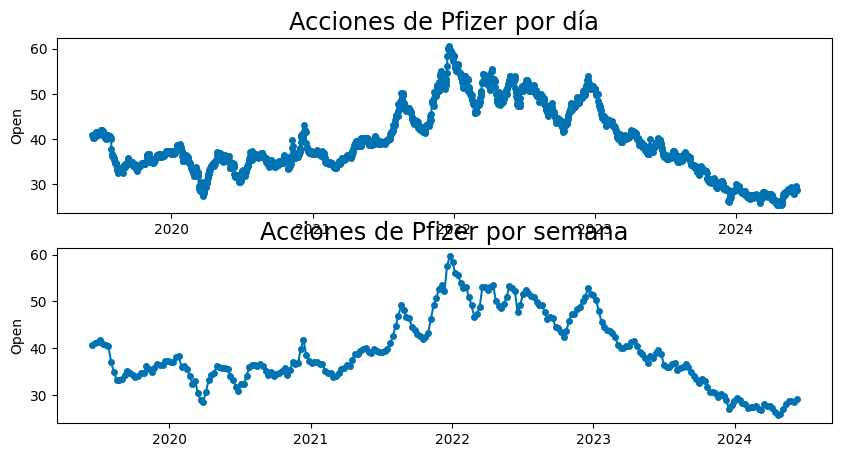

In [94]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

daily_pfizer_data = pfizer_data.copy(deep=True)
pfizer_data = reduce_df_to_weekly(pfizer_data)

plot_series(daily_pfizer_data['Open'], title='Acciones de Pfizer por día', ax=ax1)
plot_series(pfizer_data['Open'], title='Acciones de Pfizer por semana', ax=ax2)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Open'>)

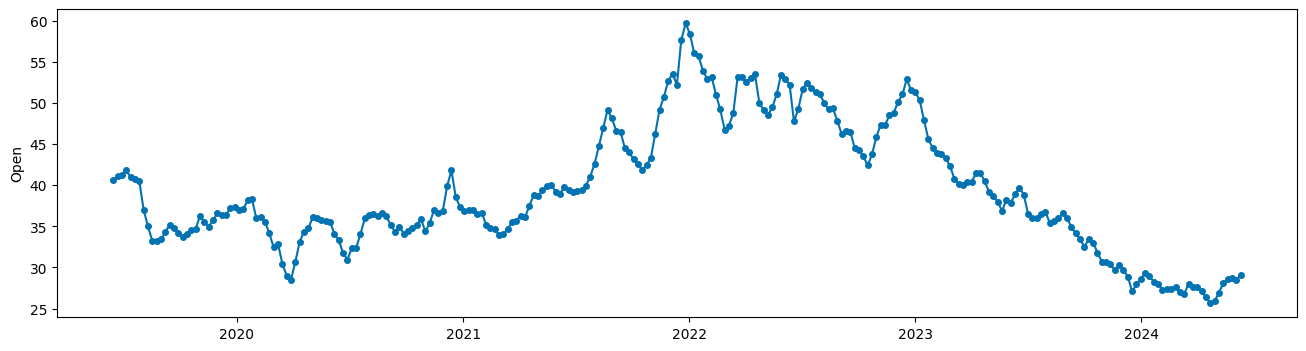

In [49]:
weekly_pfizer = reduce_df_to_weekly(fixed_pfizer)

plot_series(weekly_pfizer['Open'])

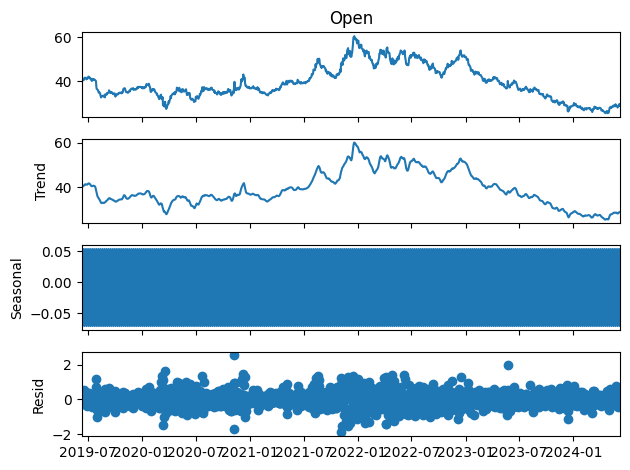

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(fixed_pfizer['Open']).plot(); None

In [101]:
pfizer_data['Date'] = pd.to_datetime(pfizer_data['Date'])
pfizer_data.set_index('Date', inplace=True)

date_range = pd.date_range(start=pfizer_data.index.min(), end=pfizer_data.index.max())

pfizer_data = pfizer_data.reindex(date_range)
pfizer_data['Close'] = pfizer_data['Close'].interpolate(method='linear')

(261, 6)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Close'>)

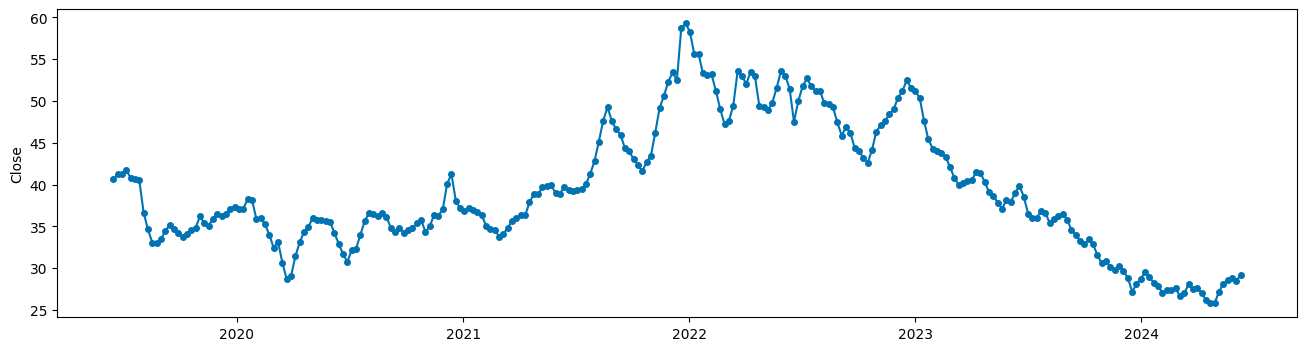

In [104]:
weekly_pfizer_data = pfizer_data.resample('w').mean()

print(weekly_pfizer_data.shape)

plot_series(weekly_pfizer_data['Close'])

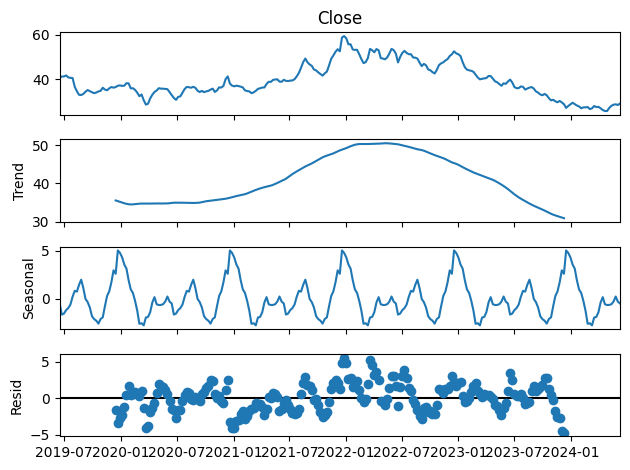

In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(weekly_pfizer_data['Close']).plot(); None

### Operaciones de transformación de datos

<!-- TODO: Explicar dataframe de datos únicos -->

<!-- TODO: Explicar dataframe multiindice para panel -->

<!-- TODO: Explicar dataframe para data streams -->

## Análisis exploratorio de datos

### Visualización de datos

<!-- TODO: Visualizar shit -->

### Tendencia y estacionalidad

<!-- TODO: Describir tendencia si la hubiera -->

<!-- TODO: Describir estacionalidad si la hubiera -->

### Estacionariedad

<!-- TODO: Explicar qué es -->

<!-- TODO: Comprobar agdfuller sin diferenciar -->

<!-- TODO: Comprobar agdfuller diferenciando -->

### Autocorrelación (_ACF_) y autocorrelación parcial (_PACF_)

<!-- TODO: Explicar por encima correlación y autocorrelación -->

<!-- TODO: Realizar graficos -->

<!-- *: Explicar valores de ACF y PACF que importan para ARIMA -->

## Uso de series temporales

### Series univariadas

### Series multivariadas

### Series de tipo *panel*

## Uso de flujos de datos (_Data Streams_)